# Preprocess data

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.io

import config
from utils import normalize

%matplotlib inline

## Load dataset

In [2]:
# Load dataset
data = pd.read_csv(
    config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_CSV,
    usecols={
        # Eye Right
        'eye_right_x':  np.int32,
        'eye_right_y':  np.int32,
        'eye_right_width':  np.int32,
        'eye_right_height': np.int32,
        'eye_right_image':  np.str,

        # Eye Left
        'eye_left_x': np.int32,
        'eye_left_y': np.int32,
        'eye_left_width': np.int32,
        'eye_left_height': np.int32,
        'eye_left_image':  np.str,

        # Face
        'face_width': np.int32,
        'face_height': np.int32,
        'face_x': np.int32,
        'face_y': np.int32,

        # Shot
        'y': np.int32,
        'x': np.int32,
        'score': np.int32,
        'timestamp':  np.int32,
        'img_path':  np.str,
        'img': np.str,  # Relative to the raw dataset

        # Game
        'game_id': np.str,
        'glasses': np.bool,
        'screen_diagonal': np.float,
        'camera_position': np.str,
        'screen_height': np.int32,
        'screen_width': np.int32,
    }
)

## Scale

Since the webcam position is Top Center, there shouldn't be negative values in the y axis.

![](img/reference.png)

In [3]:
normalize.normalize_data(data, config.WEBCAM_WIDTH, config.WEBCAM_HEIGHT)
normalize.normalize_labels(data, config.SCREEN_WIDTH, config.SCREEN_HEIGHT)

## Drop unneeded columns

In [4]:
data.drop(
    labels= [
        'score', 'timestamp', 'img_path', 'img', 'game_id', 'screen_diagonal',
        'camera_position', 'screen_height', 'screen_width'
    ],
    axis=1,
    inplace=True
)

## Clean data

In [5]:
data.describe().loc[['min','max']]

,eye_left_y,eye_left_x,face_height,face_width,eye_left_height,face_x,eye_right_x,y,x,eye_right_width,face_y,eye_right_height,eye_left_width,eye_right_y
min,0.065278,-0.707812,0.309722,0.350,0.011111,-0.778125,-0.582812,0.000000,-1.000000,0.085938,-0.043056,0.011111,0.089063,0.072222
max,0.675000,0.095312,0.644444,0.725,0.134722,0.054688,0.396875,0.998698,0.997076,0.254688,0.568056,0.145833,0.251563,0.676389


ERRORS:
* There shouldn't be negative y position values: face_y

In [6]:
data.drop(data.index[data['face_y']<0], inplace=True)

In [7]:
data.describe().loc[['min','max']]

,eye_left_y,eye_left_x,face_height,face_width,eye_left_height,face_x,eye_right_x,y,x,eye_right_width,face_y,eye_right_height,eye_left_width,eye_right_y
min,0.084722,-0.682813,0.309722,0.350,0.011111,-0.739062,-0.559375,0.000000,-1.000000,0.085938,0.026389,0.011111,0.089063,0.094444
max,0.675000,0.095312,0.644444,0.725,0.134722,0.054688,0.396875,0.998698,0.997076,0.254688,0.568056,0.145833,0.251563,0.676389


Everything makes sense.

## Target stats

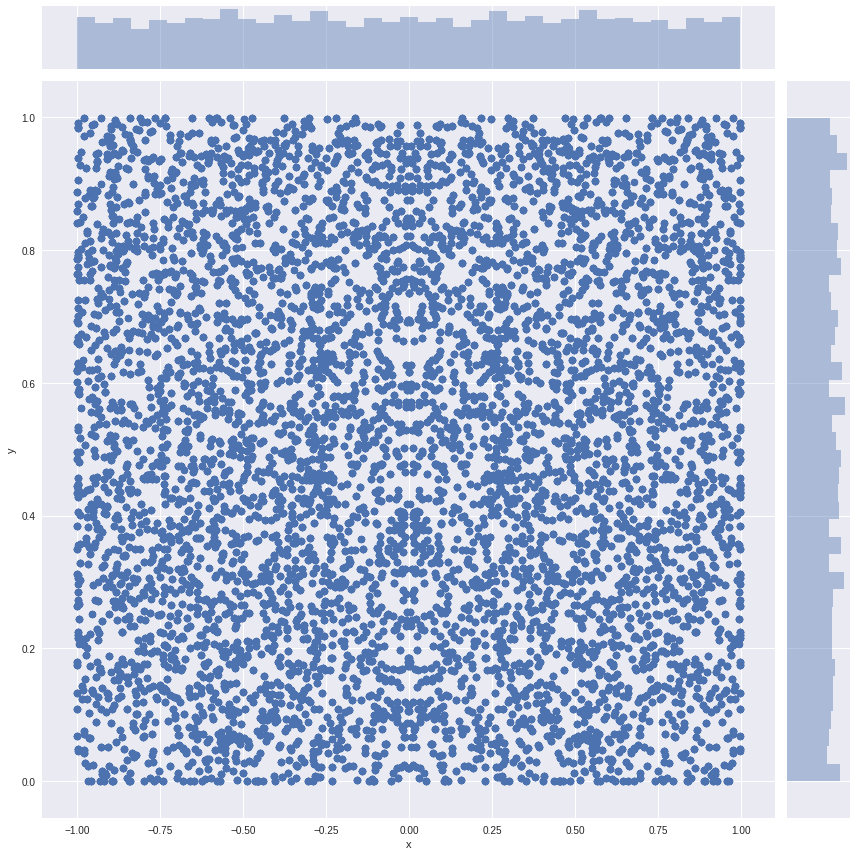

In [8]:
sns.jointplot(x="x", y="y", data=data, kind="scatter", stat_func=None, size=12, ratio=10)

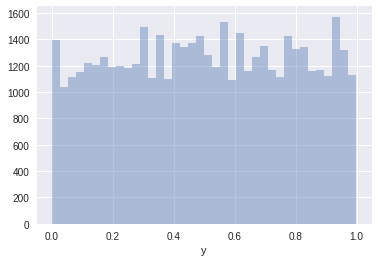

In [9]:
sns.distplot(data['y'], hist=True, norm_hist=False, kde=False)

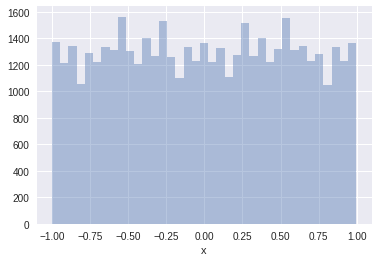

In [10]:
sns.distplot(data['x'], hist=True, norm_hist=False, kde=False)

## Eye images structure

In [11]:
imgs_left = []
imgs_right = []
errors = []

for i, row in data.iterrows():
    try:
        # Scale pixel value in range [-1,1]
        imgs_left.append((skimage.io.imread(config.PATH_DATA_FEATURES01_DLIB_AUGMENTED+row['eye_left_image'])/255-0.5)*2)
    except Exception as e:
        errors.append(path)
    try:
        # Scale pixel value in range [-1,1]
        imgs_right.append((skimage.io.imread(config.PATH_DATA_FEATURES01_DLIB_AUGMENTED+row['eye_right_image'])/255-0.5)*2)
    except Exception as e:
        errors.append(path)

## Save things

In [12]:
if not os.path.exists(config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM):
    os.makedirs(config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM)

# CSV
data.to_csv(config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_CSV, index=False)
# Images
np.save(file=config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_IMGS_LEFT, arr=imgs_left)
np.save(file=config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_IMGS_RIGHT, arr=imgs_right)